https://github.com/Amir-Hofo

--------

# 00_Arguments

In [7]:
system= "colab"
seed= False

wandb_enable= True
if wandb_enable:
  wandb_arg_name= 'Medical_Image_Segmentation'

batch_size= 32
image_channels= 3
classes= ['large_bowel', 'small_bowel', 'stomach']

backbone= 'efficientnet-b1'
pretrain_weights= 'imagenet'

lr= 0.1
momentum= 0.9
wd= 1e-4
num_epochs= 20

-----------

# 01_Library

## insatll

In [2]:
! pip install -q segmentation-models-pytorch
! pip install -q torchmetrics tqdm wandb

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## import

In [2]:
import os
from glob import glob
import urllib.request
import zipfile
from collections import Counter
import random
from typing import Any, Callable, Dict, List, Optional, Tuple

import wandb
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchmetrics as tm
from torchmetrics.aggregation import MeanMetric
from torchmetrics import Dice

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
from torchvision import transforms
from torchvision.datasets import VisionDataset
from torchvision.transforms import v2
from torchvision import tv_tensors

import cv2
from PIL import Image
import segmentation_models_pytorch as smp

In [3]:
! python --version
for lib in [torch, torchvision, smp]:
  print(lib.__name__, '-->', lib.__version__)

Python 3.11.11
torch --> 2.6.0+cu124
torchvision --> 0.21.0+cu124
segmentation_models_pytorch --> 0.4.0


-------

# 02_Utils

## system

In [8]:
if system== "local":
    project_path= r"./"
    dataset_path= './dataset/'

elif system== "colab":
    root_path= '/content/'
    project_path= r"/content/drive/MyDrive/Catalist/3_medical image segmentation/"
    dataset_path= os.path.join(project_path, r'dataset/')

else:
  raise ValueError("Invalid system")

## device

In [9]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## drive mount

In [10]:
if system== "colab":
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


## number of params fn

In [11]:
def num_trainable_params(model):
  nums= sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

## set seed

In [12]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

--------------

# 03_Data

## 3_1. download dataset

In [13]:
data_link= "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/27923/3495119/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1742638734&Signature=Jftz4DZ5iMb7ThmX3iIemrInJhU7HaMXGD4MuoAEzJ3H12MJcq3EBWwHqKP7zJH8%2FQJWcsIcJXdqu2nBOd37Kik4RvSwZenZiyroXI5oT0gTBhk5adhkYL4HSWsAV0fA0vP6QFfF%2B8LeamDNzVid%2FE4PE6hOyCvnZF3lOT60KeXZJ6BHvC5onKKagD4St8en2RAcIArb7RMaQGk%2FFkAhkZ2LcRH2I8T8C3NyoLKTmnAMDQqvLtLhJzHGNxtmt%2BzoaeOjO%2BJxPLpdCRCORa22ZFkDj6cdSRWviD4QnF8eVqzHkXN5XmrcTPpt2mDrbv96Dm%2B4GdrYcOh4Jjesl7pc4g%3D%3D&response-content-disposition=attachment%3B+filename%3Duw-madison-gi-tract-image-segmentation.zip"

files = {"dataset.zip": data_link}

for filename, url in files.items():
  if not os.path.exists(os.path.join(dataset_path, filename)):
    urllib.request.urlretrieve(url, os.path.join(dataset_path, filename))
    print(f"{filename} has been downloaded.")
  else:
    print(f"{filename} already exists.")

dataset.zip already exists.


In [14]:
data_path= os.path.join(root_path, "dataset/")
os.makedirs(data_path, exist_ok= True)
for file in files:
    with zipfile.ZipFile(os.path.join(dataset_path, file), 'r') as zip_ref:
        zip_ref.extractall(data_path)
    print(f"{file} extraction is complete.")

dataset.zip extraction is complete.


----------

## 3_2. preprocess

### load csv file

In [15]:
df= pd.read_csv(os.path.join(data_path, 'train.csv'))
df.dropna(inplace= True)
display(df.head())
df.shape

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...


(33913, 3)

### pivot table

In [16]:
df= df.pivot_table(index= 'id', columns= 'class', values= 'segmentation', aggfunc= 'first')
df.reset_index(inplace= True)
df.fillna('', inplace= True)
display(df.head())
df.shape

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...


(16590, 4)

### image pathes

In [17]:
image_path_list= glob(os.path.join(data_path, 'train', '**', '*.png'), recursive= True)

id_list= []
for i in range(0, len(image_path_list)):
  components= image_path_list[i].split(os.path.sep)[-3::2]
  id_list.append('_'.join([components[0], components[1]]).rsplit('_', 4)[0])

df_path= pd.DataFrame()
df_path['id'], df_path['path']= id_list, image_path_list
display(df_path.head())
df_path.shape

,id,path
0,case125_day16_slice_0051,/content/dataset/train/case125/case125_day16/s...
1,case125_day16_slice_0039,/content/dataset/train/case125/case125_day16/s...
2,case125_day16_slice_0120,/content/dataset/train/case125/case125_day16/s...
3,case125_day16_slice_0073,/content/dataset/train/case125/case125_day16/s...
4,case125_day16_slice_0132,/content/dataset/train/case125/case125_day16/s...


(38496, 2)

### merge paths with df

In [18]:
df= df.merge(df_path, on= 'id')
df.head()

,id,large_bowel,small_bowel,stomach,path
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,/content/dataset/train/case101/case101_day20/s...
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,/content/dataset/train/case101/case101_day20/s...
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,/content/dataset/train/case101/case101_day20/s...
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,/content/dataset/train/case101/case101_day20/s...
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,/content/dataset/train/case101/case101_day20/s...


In [19]:
df['case']= df['id'].apply(lambda x: x.split('_')[0].replace('case', ''))
df['day']= df['id'].apply(lambda x: int(x.split('_')[1].replace('day', '')))
df['slice']= df['id'].apply(lambda x: x.split('_')[3])
df['width']= df['path'].apply(lambda x: int(x[:-4].rsplit("_", 4)[1]))
df['height']= df['path'].apply(lambda x: int(x[:-4].rsplit("_", 4)[2]))
df['counts']= np.sum(df.iloc[:, 1:4] != '', axis= 1).values

display(df.head())
df['counts'].unique()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,/content/dataset/train/case101/case101_day20/s...,101,20,0066,266,266,1
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,/content/dataset/train/case101/case101_day20/s...,101,20,0067,266,266,1
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,/content/dataset/train/case101/case101_day20/s...,101,20,0068,266,266,1
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,/content/dataset/train/case101/case101_day20/s...,101,20,0069,266,266,1
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,/content/dataset/train/case101/case101_day20/s...,101,20,0070,266,266,1


array([1, 2, 3])

### create train, valid and test subset

In [20]:
print(dataset_path)

/content/drive/MyDrive/Catalist/3_medical image segmentation/dataset/


In [21]:
train_cases= open(os.path.join(dataset_path, 'train.txt')).read().replace('case', '').split('\n')
valid_cases= open(os.path.join(dataset_path, 'validation.txt')).read().replace('case', '').split('\n')
test_cases= open(os.path.join(dataset_path, 'test.txt')).read().replace('case', '').split('\n')

In [22]:
df_train= df[df['case'].isin(train_cases)]
df_valid= df[df['case'].isin(valid_cases)]
df_test= df[df['case'].isin(test_cases)]

display(df_train.head())
df_train.shape

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,/content/dataset/train/case101/case101_day20/s...,101,20,0066,266,266,1
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,/content/dataset/train/case101/case101_day20/s...,101,20,0067,266,266,1
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,/content/dataset/train/case101/case101_day20/s...,101,20,0068,266,266,1
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,/content/dataset/train/case101/case101_day20/s...,101,20,0069,266,266,1
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,/content/dataset/train/case101/case101_day20/s...,101,20,0070,266,266,1


(12030, 11)

In [23]:
df_train.to_csv(os.path.join(root_path, 'train-subset.csv'), index= False)
df_valid.to_csv(os.path.join(root_path, 'valid-subset.csv'), index= False)
df_test.to_csv(os.path.join(root_path, 'test-subset.csv'), index= False)

------------

## 3_3. EDA

In [24]:
df_train= pd.read_csv(f'{root_path}train-subset.csv')

### show random sample

In [25]:
def rle_decode(img_size, segments):
  mask= torch.zeros(3, img_size[0] * img_size[1], dtype= torch.float32)
  for i, segment in enumerate(segments):
    if str(segment) != 'nan':
      segment= segment.split()
      starts= np.array(segment[::2], dtype= np.int32) - 1
      ends= starts + np.array(segment[1::2], dtype= np.int32)
      for s, e in zip(starts, ends):
        mask[i, s:e]= 1
  return mask.reshape((3, img_size[0], img_size[1]))

In [26]:
image_transform= transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
                                     transforms.Lambda(lambda x: x.repeat(3, 1, 1))])

mask_transform= transforms.Compose([transforms.Resize((224, 224))])

red: large_bowel, green: small_bowel, blue: stomach


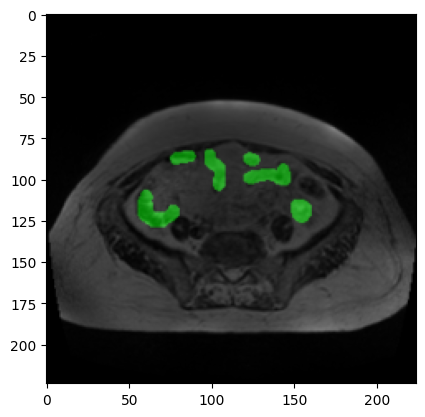

In [27]:
item= random.randint(0, df_train.shape[0])
sample= df_train.iloc[item]

img= Image.open(sample['path'])
mask= rle_decode(img.size[::-1], sample[['large_bowel', 'small_bowel', 'stomach']])

img= image_transform(img)
mask= mask_transform(mask)

plt.imshow(img.permute(1, 2, 0), cmap= 'gray')
plt.imshow(mask.permute(1, 2, 0), alpha= 0.5)
print('red: large_bowel, green: small_bowel, blue: stomach');

### size of images histogram

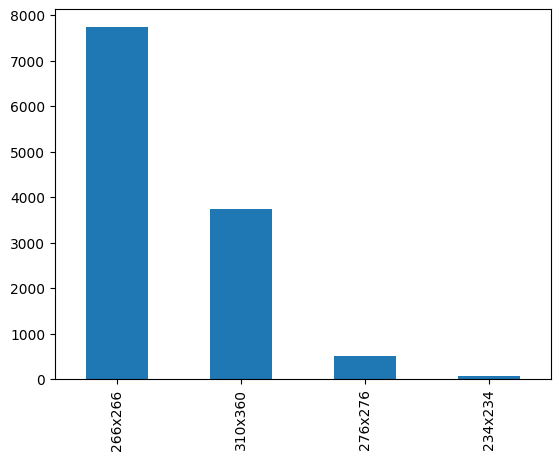

In [28]:
img_sizes= df_train['height'].apply(lambda x: str(x)) + 'x' + df_train['width'].apply(lambda x: str(x))
img_sizes.value_counts().plot(kind= 'bar');

### RAM consumption

In [29]:
total_nbytes= 0
for path in df_train['path']:
  img= cv2.imread(path)
  total_nbytes += img.nbytes
print(f'{total_nbytes/1e6:,.0f} Mb')

3,016 Mb


------------

# 04_Costum Dataset

In [30]:
def rle_decode(img_size, segments):
  mask= torch.zeros(3, img_size[0] * img_size[1], dtype= torch.int32)
  for i, segment in enumerate(segments):
    if str(segment) != 'nan':
      segment= segment.split()
      starts= np.array(segment[::2], dtype= np.int32) - 1
      ends= starts + np.array(segment[1::2], dtype= np.int32)
      for s, e in zip(starts, ends):
        mask[i, s:e]= 1
  return mask.reshape((3, img_size[0], img_size[1]))

In [31]:
class UWMadisonDataset(VisionDataset):

    def __init__(self, root: str, csv_file: str,
                 transforms: Optional[Callable]= None,
                 memory: Optional[bool]= False):

        super().__init__(root, transforms= transforms)
        self.df= pd.read_csv(os.path.join(root, csv_file))
        self.classes= ['large_bowel', 'small_bowel', 'stomach']
        self.memory= memory
        if memory: self._save_memory()

    def _save_memory(self):
      self.imgs= []
      for path in self.df['path']:
        self.imgs.append(self._load_image(path))

    def _load_image(self, path):
      img= cv2.imread(path, cv2.IMREAD_UNCHANGED)
      img= self._minmax_scaler(img)
      return tv_tensors.Image(img)

    def _minmax_scaler(self, x):
      return np.array((x - x.min()) / (x.max() - x.min()), dtype= np.float32)

    def __getitem__(self, item):
        sample= self.df.iloc[item]
        img= self.imgs[item] if self.memory else self._load_image(sample['path'])
        mask= rle_decode(img.shape[1::], sample[self.classes])
        mask= tv_tensors.Mask(mask)
        img, mask= self.transforms(img, mask)
        return img, mask.int()

    def __len__(self):
        return self.df.shape[0]

### transform

In [32]:
transform_train= v2.Compose([
    v2.Resize(size= (234,), antialias= True),
    v2.RandomCrop(size= (224, 224)),
    v2.RandomPhotometricDistort(p= 0.5),
    v2.RandomHorizontalFlip(p= 0.5),
    v2.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
    v2.Normalize(mean= (0.5,), std= (0.5,)),
    v2.Lambda(lambda x: x.repeat(3, 1, 1)),
    ])

transform_eval= v2.Compose([
    v2.Resize(size= (224, 224), antialias= True),
    v2.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
    v2.Normalize(mean= (0.5,), std= (0.5,)),
    v2.Lambda(lambda x: x.repeat(3, 1, 1)),
    ])

### dataset

In [33]:
train_set= UWMadisonDataset(root_path, 'train-subset.csv',
                            transforms=transform_train, memory= True)
valid_set= UWMadisonDataset(root_path, 'valid-subset.csv',
                            transforms=transform_eval, memory= True)
test_set= UWMadisonDataset(root_path, 'test-subset.csv',
                           transforms=transform_eval)

len(train_set), len(valid_set), len(test_set)

(12030, 1493, 3067)

### show random samples

torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) [-1.0, 1.0] tensor([0, 1], dtype=torch.int32)


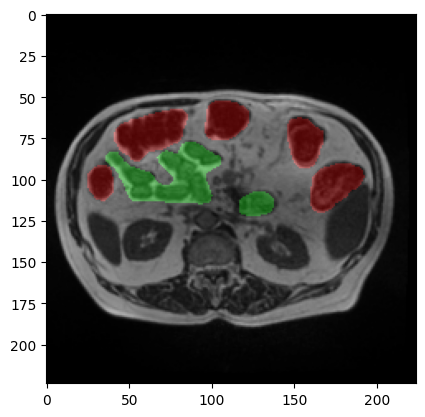

In [34]:
item= random.randint(0, len(train_set))
img, mask= train_set[item]
print(img.shape, mask.shape, [img.min().item(), img.max().item()], mask.unique())

plt.imshow(img[0], cmap= 'gray')
plt.imshow(mask.permute(1, 2, 0).float(), alpha= 0.3);

torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) [-1.0, 1.0] tensor([0, 1], dtype=torch.int32)


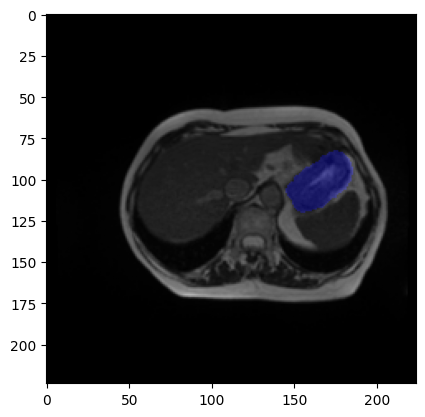

In [35]:
item= random.randint(0, len(test_set))
img, mask= test_set[item]
print(img.shape, mask.shape, [img.min().item(), img.max().item()], mask.unique())

plt.imshow(img[0], cmap= 'gray')
plt.imshow(mask.permute(1, 2, 0).float(), alpha= 0.3);

### dataloader

In [36]:
train_loader= DataLoader(train_set, batch_size= batch_size, shuffle= True)
valid_loader= DataLoader(valid_set, batch_size= batch_size, shuffle= False)
test_loader= DataLoader(test_set, batch_size= batch_size, shuffle= False)

In [37]:
print("train batch size:",train_loader.batch_size,
     ", num of batch:", len(train_loader))
print("valid batch size:",valid_loader.batch_size,
     ", num of batch:", len(valid_loader))
print("Test batch size:",test_loader.batch_size,
     ", num of batch:", len(test_loader))

train batch size: 32 , num of batch: 376
valid batch size: 32 , num of batch: 47
Test batch size: 32 , num of batch: 96


-----------

# 05_Model

In [ ]:
model= smp.Unet(encoder_name= backbone, encoder_weights= pretrain_weights,
                in_channels= image_channels, classes= len(classes)).to(device)
model

## config

In [39]:
if wandb_enable:
  key_file= os.path.join(project_path, 'key.txt')
  if os.path.exists(key_file):
      with open(key_file) as f:
          key= f.readline().strip()
      wandb.login(key= key)
  else:
      print("Key file does not exist. ",
          "Please create the key file with your wandb API key.")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amirhossien922 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [40]:
loss_fn= smp.losses.DiceLoss(mode= 'multilabel')
metric= Dice().to(device)

-------------

# 06_one epoch fn

In [41]:
def train_one_epoch(model, train_loader, loss_fn,
                    optimizer, metric, epoch= None):
  model.train()
  loss_train= MeanMetric()
  metric.reset()

  with tqdm.tqdm(train_loader, unit= 'batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs, targets= inputs.to(device), targets.to(device)
      outputs= model(inputs)
      loss= loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), weight= len(targets))
      metric.update(outputs, targets)
      tepoch.set_postfix(loss= loss_train.compute().item(),
                         metric= metric.compute().item())

  return model, loss_train.compute().item(), metric.compute().item()

In [42]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval= MeanMetric()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs, targets= inputs.to(device), targets.to(device)
      outputs= model(inputs)
      loss= loss_fn(outputs, targets)

      loss_eval.update(loss.item(), weight= len(targets))
      metric(outputs, targets)

  return loss_eval.compute().item(), metric.compute().item()

-------------

# 07_Set Hyperparameters

## base loss

In [43]:
model= smp.Unet(encoder_name= backbone, encoder_weights= pretrain_weights,
                in_channels= image_channels, classes= len(classes)).to(device)

loss_base, metric_base= evaluate(model, valid_loader, loss_fn, metric)
print(f'loss base: {loss_base:.2f}, metric base: {metric_base:.2f}')

loss base: 0.96, metric base: 0.02


## grid search

In [44]:
num_epochs= 3

for lr in [1, 0.1, 0.01]:
  print(f'LR={lr}')

  model= smp.Unet(encoder_name= backbone, encoder_weights= pretrain_weights,
                  in_channels= image_channels, classes= len(classes)).to(device)
  optimizer= optim.SGD(model.parameters(), lr= lr,
                       weight_decay= wd, momentum= momentum)

  for epoch in range(num_epochs):
    model, _, _= train_one_epoch(model, valid_loader, loss_fn, optimizer, metric, epoch+1)
  loss_grid, metric_grid= evaluate(model, valid_loader, loss_fn, metric)
  print(f'loss: {loss_grid:.2f}, metric: {metric_grid:.2f}')
  print()

LR=1


Epoch 3: 100%|██████████| 47/47 [00:28<00:00,  1.63batch/s, loss=0.768, metric=0.298]


loss: 0.95, metric: 0.03

LR=0.1


Epoch 3: 100%|██████████| 47/47 [00:32<00:00,  1.44batch/s, loss=0.638, metric=0.353]


loss: 0.67, metric: 0.32

LR=0.01


Epoch 3: 100%|██████████| 47/47 [00:29<00:00,  1.61batch/s, loss=0.935, metric=0.0757]


loss: 0.94, metric: 0.07



---------

# 08_Training

## create new model

In [45]:
loss_train_hist, loss_valid_hist= [], []
metric_train_hist, metric_valid_hist= [], []
best_loss_valid= torch.inf
epoch_counter= 0

if seed: set_seed(seed)

model= smp.Unet(encoder_name= backbone, encoder_weights= pretrain_weights,
                in_channels= image_channels, classes= len(classes)).to(device)


## set optimizer

In [ ]:
lr= 0.3
num_epochs= 15
# model= torch.load(f'{project_path}model.pt', map_location= device)
optimizer= optim.SGD(model.parameters(), lr= lr,
                     weight_decay= wd, momentum= momentum)

lr_scheduler= optim.lr_scheduler.MultiStepLR(optimizer,
                                             milestones= [5, 10, 15],
                                             gamma= 0.1)

## initialize wandb

In [ ]:
if wandb_enable:
  wandb.init(
      project=...,
      name=wandb_arg_name,
      config={
          'backbone': backbone
          'pretrain_weights': pretrain_weights
          'lr': lr,
          'momentum': momentum,
          'wd': 1e-4,
          'batch_size': batch_size,
          'num_epochs': num_epochs,
          'lr_scheduler': [5, 10, 15],
          'gamma': 0.1}
  )

## main loop

In [ ]:
for epoch in range(num_epochs):
  model, loss_train, metric_train= train_one_epoch(model, train_loader,
                                                   loss_fn, optimizer,
                                                   metric, epoch+1)
  loss_valid, metric_valid= evaluate(model, valid_loader, loss_fn, metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid= loss_valid
    print('Model Saved!')

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print(f'LR = {lr_scheduler.get_last_lr()[0]}')
  print()

  lr_scheduler.step()

  epoch_counter += 1

In [ ]:
if wandb_enable: wandb.finish()

--------

# 09_Learning curve

In [ ]:
plt.plot(range(len(loss_train_hist)), loss_train_hist, 'k-', label= 'Train')
plt.plot(range(len(loss_valid_hist)), loss_valid_hist, 'b-', label= 'Validation')

plt.xlabel('Epoch')
plt.ylabel('DiceLoss')
plt.grid(True)
plt.legend()

In [ ]:
plt.plot(range(len(metric_train_hist)), metric_train_hist, 'k-', label= 'Train')
plt.plot(range(len(metric_valid_hist)), metric_valid_hist, 'b-', label= 'Validation')

plt.xlabel('Epoch')
plt.ylabel('Dice Metric')
plt.grid(True)
plt.legend()

-------

# 10_Test

In [ ]:
model= torch.load(f'{project_path}model.pt', map_location= device)
model.eval()
loss_test, metric_test= evaluate(model, test_loader, loss_fn, metric)
print(f'loss: {loss_test:.2f}, metric: {metric_test:.2f}')

In [ ]:
def segment(image, model):
  with torch.inference_mode():
    prediction= model(image)
    return torch.sigmoid(prediction).cpu()

In [ ]:
img, mask = next(iter(test_loader))

output = segment(img.to(device), model)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(img[0, 0], cmap='gray');
plt.title('Input')

plt.subplot(1, 3, 2)
plt.imshow(img[0, 0], cmap='gray');
plt.imshow(output[0].permute(1, 2, 0), alpha=0.3);
plt.title('Model')

plt.subplot(1, 3, 3)
plt.imshow(img[0, 0], cmap='gray');
plt.imshow(mask[0].permute(1, 2, 0).float(), alpha=0.3);
plt.title('Target');